In [1]:
import os
import cv2
import math
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score
from keras import optimizers
from keras import backend as K
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, Activation, BatchNormalization

# Set seeds to make the experiment more reproducible.
from tensorflow import set_random_seed
from numpy.random import seed
set_random_seed(0)
seed(0)

%matplotlib inline
sns.set(style="whitegrid")
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
train = pd.read_csv('../input/imet-2019-fgvc6/train.csv')
labels = pd.read_csv('../input/imet-2019-fgvc6/labels.csv')
test = pd.read_csv('../input/imet-2019-fgvc6/sample_submission.csv')

train["attribute_ids"] = train["attribute_ids"].apply(lambda x:x.split(" "))
train["id"] = train["id"].apply(lambda x: x + ".png")
test["id"] = test["id"].apply(lambda x: x + ".png")

print('Number of train samples: ', train.shape[0])
print('Number of test samples: ', test.shape[0])
print('Number of labels: ', labels.shape[0])
display(train.head())
display(labels.head())

Number of train samples:  109237
Number of test samples:  7443
Number of labels:  1103


,id,attribute_ids
0,1000483014d91860.png,"[147, 616, 813]"
1,1000fe2e667721fe.png,"[51, 616, 734, 813]"
2,1001614cb89646ee.png,[776]
3,10041eb49b297c08.png,"[51, 671, 698, 813, 1092]"
4,100501c227f8beea.png,"[13, 404, 492, 903, 1093]"


,attribute_id,attribute_name
0,0,culture::abruzzi
1,1,culture::achaemenid
2,2,culture::aegean
3,3,culture::afghan
4,4,culture::after british


### Bottleneck features using VGG16

In [3]:
# Model parameters
BATCH_SIZE = 64
EPOCHS = 200
LEARNING_RATE = 0.0001
HEIGHT = 128
WIDTH = 128
CANAL = 3
N_CLASSES = labels.shape[0]
ES_PATIENCE = 5
DECAY_DROP = 0.5
DECAY_EPOCHS = 10
classes = list(map(str, range(N_CLASSES)))

In [4]:
def f2_score_thr(threshold=0.5):
    def f2_score(y_true, y_pred):
        beta = 2
        y_pred = K.cast(K.greater(K.clip(y_pred, 0, 1), threshold), K.floatx())

        true_positives = K.sum(K.clip(y_true * y_pred, 0, 1), axis=1)
        predicted_positives = K.sum(K.clip(y_pred, 0, 1), axis=1)
        possible_positives = K.sum(K.clip(y_true, 0, 1), axis=1)

        precision = true_positives / (predicted_positives + K.epsilon())
        recall = true_positives / (possible_positives + K.epsilon())

        return K.mean(((1+beta**2)*precision*recall) / ((beta**2)*precision+recall+K.epsilon()))
    return f2_score

def step_decay(epoch):
    initial_lrate = LEARNING_RATE
    drop = DECAY_DROP
    epochs_drop = DECAY_EPOCHS
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    return lrate

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train,
    directory="../input/imet-2019-fgvc6/train",
    x_col="id",
    y_col="attribute_ids",
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode=None,
    target_size=(HEIGHT, WIDTH))

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=test,
        directory = "../input/imet-2019-fgvc6/test",    
        x_col="id",
        target_size=(HEIGHT, WIDTH),
        batch_size=1,
        shuffle=False,
        class_mode=None)

Found 109237 images.
Found 7443 images.


In [6]:
# Build the VGG16 network
model_vgg = VGG16(weights=None, include_top=False)
model_vgg.load_weights('../input/vgg16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5')

STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size

train_data = model_vgg.predict_generator(train_generator, STEP_SIZE_TRAIN)

train_labels = []
for label in train['attribute_ids'][:train_data.shape[0]].values:
    zeros = np.zeros(N_CLASSES)
    for label_i in label:
        zeros[int(label_i)] = 1
    train_labels.append(zeros)
    
train_labels = np.asarray(train_labels)

X_train, X_val, Y_train, Y_val = train_test_split(train_data, train_labels, test_size=0.2, random_state=0)

Instructions for updating:
Colocations handled automatically by placer.


### Model

In [7]:
model = Sequential()
model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(2048, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(N_CLASSES, activation="sigmoid"))

optimizer = optimizers.Adam(lr=LEARNING_RATE)
thresholds = [0.1, 0.15, 0.2, 0.25, 0.28, 0.3, 0.4, 0.5]
metrics = ["accuracy", "categorical_accuracy", f2_score_thr(0.1), f2_score_thr(0.15), f2_score_thr(0.2), 
           f2_score_thr(0.25), f2_score_thr(0.28), f2_score_thr(0.3), f2_score_thr(0.4), f2_score_thr(0.5)]
lrate = LearningRateScheduler(step_decay)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=ES_PATIENCE)
callbacks = [es]
model.compile(optimizer=optimizer, loss="binary_crossentropy",  metrics=metrics)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [8]:
history = model.fit(x=X_train, y=Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=EPOCHS,
                    batch_size=BATCH_SIZE,
                    callbacks=callbacks,
                    verbose=2)

Instructions for updating:
Use tf.cast instead.
Train on 87347 samples, validate on 21837 samples
Epoch 1/200
 - 18s - loss: 0.0206 - acc: 0.9945 - categorical_accuracy: 0.0901 - f2_score: 0.2118 - f2_score_1: 0.1810 - f2_score_2: 0.1518 - f2_score_3: 0.1266 - f2_score_4: 0.1136 - f2_score_5: 0.1057 - f2_score_6: 0.0725 - f2_score_7: 0.0485 - val_loss: 0.0123 - val_acc: 0.9972 - val_categorical_accuracy: 0.1473 - val_f2_score: 0.3079 - val_f2_score_1: 0.2492 - val_f2_score_2: 0.1985 - val_f2_score_3: 0.1571 - val_f2_score_4: 0.1359 - val_f2_score_5: 0.1238 - val_f2_score_6: 0.0783 - val_f2_score_7: 0.0502
Epoch 2/200
 - 16s - loss: 0.0125 - acc: 0.9972 - categorical_accuracy: 0.1402 - f2_score: 0.3170 - f2_score_1: 0.2808 - f2_score_2: 0.2421 - f2_score_3: 0.2072 - f2_score_4: 0.1879 - f2_score_5: 0.1760 - f2_score_6: 0.1263 - f2_score_7: 0.0893 - val_loss: 0.0117 - val_acc: 0.9973 - val_categorical_accuracy: 0.1273 - val_f2_score: 0.3432 - val_f2_score_1: 0.2925 - val_f2_score_2: 0.24

### Model graph loss

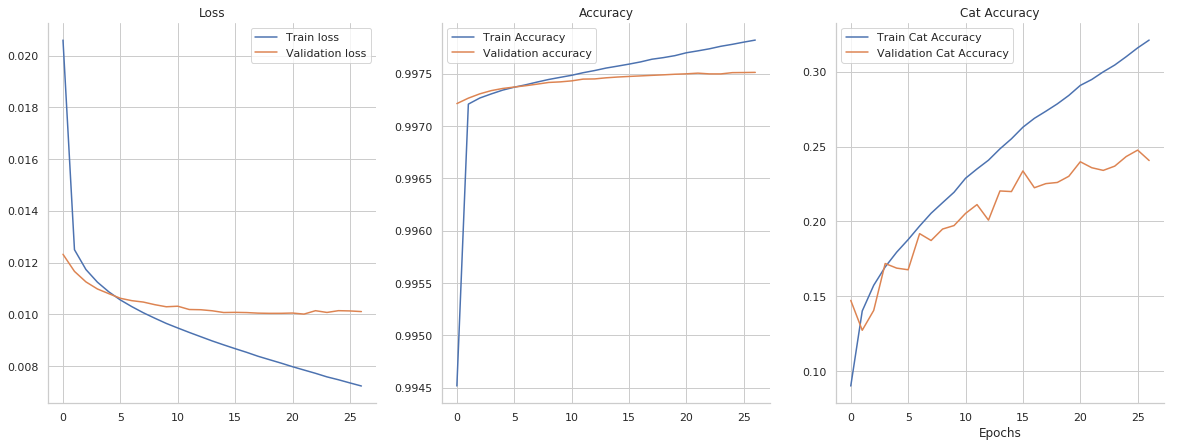

In [9]:
sns.set_style("whitegrid")
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', figsize=(20,7))


ax1.plot(history.history['loss'], label='Train loss')
ax1.plot(history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('Loss')

ax2.plot(history.history['acc'], label='Train Accuracy')
ax2.plot(history.history['val_acc'], label='Validation accuracy')
ax2.legend(loc='best')
ax2.set_title('Accuracy')

ax3.plot(history.history['categorical_accuracy'], label='Train Cat Accuracy')
ax3.plot(history.history['val_categorical_accuracy'], label='Validation Cat Accuracy')
ax3.legend(loc='best')
ax3.set_title('Cat Accuracy')

plt.xlabel('Epochs')
sns.despine()
plt.show()

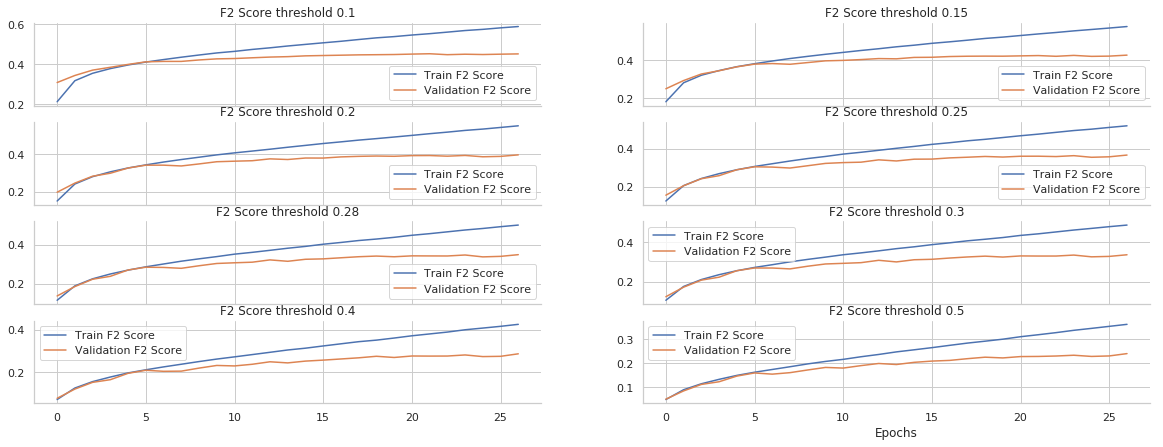

In [10]:
fig, axes = plt.subplots(4, 2, sharex='col', figsize=(20,7))

axes[0][0].plot(history.history['f2_score'], label='Train F2 Score')
axes[0][0].plot(history.history['val_f2_score'], label='Validation F2 Score')
axes[0][0].legend(loc='best')
axes[0][0].set_title('F2 Score threshold 0.1')

axes[0][1].plot(history.history['f2_score_1'], label='Train F2 Score')
axes[0][1].plot(history.history['val_f2_score_1'], label='Validation F2 Score')
axes[0][1].legend(loc='best')
axes[0][1].set_title('F2 Score threshold 0.15')

axes[1][0].plot(history.history['f2_score_2'], label='Train F2 Score')
axes[1][0].plot(history.history['val_f2_score_2'], label='Validation F2 Score')
axes[1][0].legend(loc='best')
axes[1][0].set_title('F2 Score threshold 0.2')

axes[1][1].plot(history.history['f2_score_3'], label='Train F2 Score')
axes[1][1].plot(history.history['val_f2_score_3'], label='Validation F2 Score')
axes[1][1].legend(loc='best')
axes[1][1].set_title('F2 Score threshold 0.25')

axes[2][0].plot(history.history['f2_score_4'], label='Train F2 Score')
axes[2][0].plot(history.history['val_f2_score_4'], label='Validation F2 Score')
axes[2][0].legend(loc='best')
axes[2][0].set_title('F2 Score threshold 0.28')

axes[2][1].plot(history.history['f2_score_5'], label='Train F2 Score')
axes[2][1].plot(history.history['val_f2_score_5'], label='Validation F2 Score')
axes[2][1].legend(loc='best')
axes[2][1].set_title('F2 Score threshold 0.3')

axes[3][0].plot(history.history['f2_score_6'], label='Train F2 Score')
axes[3][0].plot(history.history['val_f2_score_6'], label='Validation F2 Score')
axes[3][0].legend(loc='best')
axes[3][0].set_title('F2 Score threshold 0.4')

axes[3][1].plot(history.history['f2_score_7'], label='Train F2 Score')
axes[3][1].plot(history.history['val_f2_score_7'], label='Validation F2 Score')
axes[3][1].legend(loc='best')
axes[3][1].set_title('F2 Score threshold 0.5')

plt.xlabel('Epochs')
sns.despine()
plt.show()

### Find best threshold value

In [11]:
best_thr = 0
best_thr_val = history.history['val_f2_score'][-1]
for i in range(1, len(metrics)-2):
    if best_thr_val < history.history['val_f2_score_%s' % i][-1]:
        best_thr_val = history.history['val_f2_score_%s' % i][-1]
        best_thr = i

threshold = thresholds[best_thr]
print('Best threshold is: %s' % threshold)

Best threshold is: 0.1


### Apply model to test set and output predictions

In [12]:
test_generator.reset()
STEP_SIZE_TEST = test_generator.n//test_generator.batch_size
bottleneck_preds = model_vgg.predict_generator(test_generator, steps=STEP_SIZE_TEST)
preds = model.predict(bottleneck_preds)

In [13]:
predictions = []
for pred_ar in preds:
    valid = ''
    for idx, pred in enumerate(pred_ar):
        if pred > threshold:
            if len(valid) == 0:
                valid += str(idx)
            else:
                valid += (' %s' % idx)
    if len(valid) == 0:
        valid = str(np.argmax(pred_ar))
    predictions.append(valid)

In [14]:
filenames = test_generator.filenames
results = pd.DataFrame({'id':filenames, 'attribute_ids':predictions})
results['id'] = results['id'].map(lambda x: str(x)[:-4])
results.to_csv('submission.csv',index=False)
results.head(10)

,id,attribute_ids
0,10023b2cc4ed5f68,121 343 369 477 766 1059
1,100fbe75ed8fd887,121 1039 1059
2,101b627524a04f19,79 482 497 498 961
3,10234480c41284c6,13 51 483 725 738 776 830 1046
4,1023b0e2636dcea8,147 156 189 283 322 420 584 813 835 954 1092
5,1039cd6cf85845c,13 405 896 903 1092
6,103a5b3f83fbe88,51 194 744 813 1046 1092
7,10413aaae8d6a9a2,51 147 813 1046 1092
8,10423822b93a65ab,51 147 1046
9,1052bf702cb099f7,147 188 597 671 723 780
